In [7]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Validate Halo Model Calulations

In [8]:
# load a test halo catalog

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')

## Calulate Orientation Correlation Functions

In [9]:
from halotools.mock_observables.alignments import ed_3d, ee_3d, ee_3d_one_two_halo_decomp, ed_3d_one_two_halo_decomp

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [10]:
# empirical halo and sub-halo correlations

halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

# define host and sub-halo samples
hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1

# define host halo IDs
host_ids = halocat.halo_table['halo_hostid']

# define halo sub-samples
halo_sample_mask = (halocat.halo_table['halo_mpeak']>10**12.0)

In [12]:
# calculate ED correaltion functions
halo_omega_1h, halo_omega_2h = ed_3d_one_two_halo_decomp(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                                         host_ids[halo_sample_mask],
                                                         halo_coords[halo_sample_mask], host_ids[halo_sample_mask],
                                                         rbins, period=halocat.Lbox, num_threads=4)

halo_omega = halo_omega_1h + halo_omega_2h

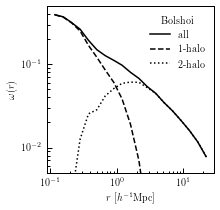

In [13]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_omega, '-', color='black')
l2, = plt.plot(rbin_centers, halo_omega_1h, '--', color='black')
l3, = plt.plot(rbin_centers, halo_omega_2h, ':', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\omega(r)$')
plt.ylim([0.005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'],
           frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

In [14]:
# calculate EE correaltion functions
halo_eta_1h, halo_eta_2h = ee_3d_one_two_halo_decomp(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                                     host_ids[halo_sample_mask],
                                                     halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                                     host_ids[halo_sample_mask],
                                                     rbins, period=halocat.Lbox, num_threads=4)

halo_eta = halo_eta_1h + halo_eta_2h

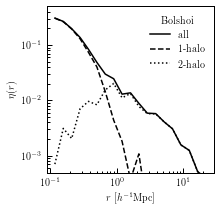

In [15]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_eta, '-', color='black')
l2, = plt.plot(rbin_centers, halo_eta_1h, '--', color='black')
l3, = plt.plot(rbin_centers, halo_eta_2h, ':', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.0005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'],
           frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

In [60]:
from halotools.mock_observables import cuboid_subvolume_labels

def jackknife_ee_3d_one_two_halo_decomp(coords_1, orientations_1, host_ids_1,
                                        coords_2, orientations_2, host_ids_2,
                                        rbins, period, num_threads, Nsub):
    """
    calculate jackknife errors for EE correlation function
    """
    
    labels_1 = cuboid_subvolume_labels(coords_1, Nsub, period)[0]
    labels_2 = cuboid_subvolume_labels(coords_2, Nsub, period)[0]
    
    Njack = np.prod(Nsub)
    result_1h = np.zeros((Njack, len(rbins)-1))
    result_2h = np.zeros((Njack, len(rbins)-1))
    for i in range(1,Njack+1):
        mask_1 = (labels_1 != i)
        mask_2 = (labels_2 != i)
        print(i,np.sum(mask_1),np.sum(mask_2))
        result_1h[i-1,:], result_2h[i-1,:] = ee_3d_one_two_halo_decomp(coords_1[mask_1], orientations_1[mask_1], host_ids_1[mask_1],
                coords_2[mask_2], orientations_2[mask_2], host_ids_2[mask_2],
                rbins,  period=period, num_threads=num_threads)
    
    return result_1h, result_2h

def jackknife_ed_3d_one_two_halo_decomp(coords_1, orientations_1, host_ids_1,
                                        coords_2, host_ids_2,
                                        rbins, period, num_threads, Nsub):
    """
    calculate jackknife errors for EE correlation function
    """
    
    labels_1 = cuboid_subvolume_labels(coords_1, Nsub, period)[0]
    labels_2 = cuboid_subvolume_labels(coords_2, Nsub, period)[0]
    
    Njack = np.prod(Nsub)
    result_1h = np.zeros((Njack, len(rbins)-1))
    result_2h = np.zeros((Njack, len(rbins)-1))
    for i in range(1,Njack+1):
        mask_1 = (labels_1 != i)
        mask_2 = (labels_2 != i)
        print(i,np.sum(mask_1),np.sum(mask_2))
        result_1h[i-1,:], result_2h[i-1,:] = ed_3d_one_two_halo_decomp(coords_1[mask_1], orientations_1[mask_1], host_ids_1[mask_1],
                coords_2[mask_2], host_ids_2[mask_2],
                rbins,  period=period, num_threads=num_threads)
    
    return result_1h, result_2h

In [61]:
result1_ed, result2_ed = jackknife_ed_3d_one_two_halo_decomp(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                    host_ids[halo_sample_mask],
                                    halo_coords[halo_sample_mask],
                                    host_ids[halo_sample_mask],
                                    rbins, halocat.Lbox, 4, [3,3,3])

[ 1  1  1 ... 27 27 27]
1 68259 68259
2 68242 68242
3 68880 68880
4 68378 68378
5 69318 69318
6 68304 68304
7 68374 68374
8 68494 68494
9 68147 68147
10 68008 68008
11 68666 68666
12 68304 68304
13 69194 69194
14 68933 68933
15 69209 69209
16 68973 68973
17 68682 68682
18 68671 68671
19 68177 68177
20 68656 68656
21 68319 68319
22 68333 68333
23 68988 68988
24 67078 67078
25 68722 68722
26 68477 68477
27 68686 68686


In [65]:
err_1 = np.sqrt(np.diag(np.cov(result1_ed.T, bias=True))*(27-1.0))
err_2 = np.sqrt(np.diag(np.cov(result2_ed.T, bias=True))*(27-1.0))

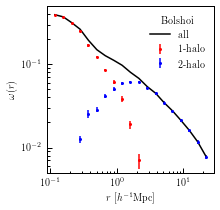

In [66]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_omega, '-', color='black')
l2 = plt.errorbar(rbin_centers, halo_omega_1h, yerr=err_1, fmt='o', ms=2, color='red')
l3 = plt.errorbar(rbin_centers, halo_omega_2h, yerr=err_2, fmt='o', ms=2, color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\omega(r)$')
plt.ylim([0.005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'],
           frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

In [46]:
result1_ee, result2_ee = jackknife_ee_3d_one_two_halo_decomp(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                    host_ids[halo_sample_mask],
                                    halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                    host_ids[halo_sample_mask],
                                    rbins, halocat.Lbox, 4, [3,3,3])

[ 1  1  1 ... 27 27 27]
1 68259 68259
2 68242 68242
3 68880 68880
4 68378 68378
5 69318 69318
6 68304 68304
7 68374 68374
8 68494 68494
9 68147 68147
10 68008 68008
11 68666 68666
12 68304 68304
13 69194 69194
14 68933 68933
15 69209 69209
16 68973 68973
17 68682 68682
18 68671 68671
19 68177 68177
20 68656 68656
21 68319 68319
22 68333 68333
23 68988 68988
24 67078 67078
25 68722 68722
26 68477 68477
27 68686 68686


In [57]:
err_1 = np.sqrt(np.diag(np.cov(result1_ee.T, bias=True))*(27-1.0))
err_2 = np.sqrt(np.diag(np.cov(result2_ee.T, bias=True))*(27-1.0))

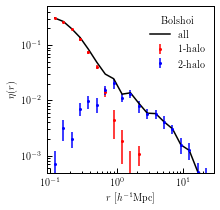

In [59]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_eta, '-', color='black')
l2 = plt.errorbar(rbin_centers, halo_eta_1h, yerr=err_1, fmt='o', ms=2, color='red')
l3 = plt.errorbar(rbin_centers, halo_eta_2h, yerr=err_2, fmt='o', ms=2, color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.0005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'],
           frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()